# Emotion Classification from Human Faces USing ResNet-18-based Models

In [46]:
import os
import random
import time
from dataclasses import dataclass
from typing import Dict, Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.models.resnet import ResNet

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from tqdm import tqdm
import matplotlib.pyplot as plt

## Utils

In [ ]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_device() -> torch.device:
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preapre data

In [ ]:
def find_dataset_root(base_dir: str) -> str:
    
    IMG_EXT = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
    candidates = []
    for root, dirs, files in os.walk(base_dir):
        if len(dirs) >= 2:
            has_img = False
            for d in dirs[:10]:
                p = os.path.join(root, d)
                if os.path.isdir(p):
                    for f in os.listdir(p)[:200]:
                        if f.lower().endswith(IMG_EXT):
                            has_img = True
                            break
                if has_img:
                    break
            if has_img:
                candidates.append(root)

    if not candidates:
        raise FileNotFoundError(
            f"Data root directory not found: Please verify that {base_dir} contains a structure like data_root/<class_name>/*.jpg"
        )
    candidates.sort(key=lambda x: len(x.split(os.sep)))
    return candidates[0]


def build_transforms(img_size: int = 224):
    imagenet_mean = (0.485, 0.456, 0.406)
    imagenet_std = (0.229, 0.224, 0.225)

    train_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ])

    eval_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ])
    return train_tf, eval_tf


def stratified_split_indices(targets: List[int], train_ratio=0.8, val_ratio=0.1, seed=42):
    
    targets = np.array(targets)
    indices = np.arange(len(targets))

    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(1 - train_ratio), random_state=seed)
    train_idx, temp_idx = next(sss1.split(indices, targets))

    temp_targets = targets[temp_idx]
    val_size = val_ratio / (1 - train_ratio)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=(1 - val_size), random_state=seed)
    val_rel_idx, test_rel_idx = next(sss2.split(temp_idx, temp_targets))

    val_idx = temp_idx[val_rel_idx]
    test_idx = temp_idx[test_rel_idx]
    return train_idx, val_idx, test_idx


def make_dataloaders(
    data_dir: str,
    batch_size: int,
    num_workers: int,
    seed: int,
    img_size: int = 224,
) -> Tuple[DataLoader, DataLoader, DataLoader, Dict]:
    
    train_tf, eval_tf = build_transforms(img_size=img_size)

    base_ds = datasets.ImageFolder(root=data_dir, transform=eval_tf)
    class_names = base_ds.classes
    num_classes = len(class_names)

    train_idx, val_idx, test_idx = stratified_split_indices(
        targets=base_ds.targets, train_ratio=0.8, val_ratio=0.1, seed=seed
    )

    train_ds = datasets.ImageFolder(root=data_dir, transform=train_tf)
    val_ds = datasets.ImageFolder(root=data_dir, transform=eval_tf)
    test_ds = datasets.ImageFolder(root=data_dir, transform=eval_tf)

    train_subset = Subset(train_ds, train_idx)
    val_subset = Subset(val_ds, val_idx)
    test_subset = Subset(test_ds, test_idx)

    counts = np.bincount(np.array(base_ds.targets), minlength=num_classes)
    class_weights = (counts.sum() / (counts + 1e-6))
    class_weights = class_weights / class_weights.sum() * num_classes

    meta = {
        "class_names": class_names,
        "num_classes": num_classes,
        "counts": counts,
        "class_weights": class_weights.astype(np.float32),
        "sizes": {"train": len(train_idx), "val": len(val_idx), "test": len(test_idx)},
    }

    g = torch.Generator()
    g.manual_seed(seed)

    train_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, generator=g
    )
    val_loader = DataLoader(
        val_subset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    test_loader = DataLoader(
        test_subset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    return train_loader, val_loader, test_loader, meta

## Define model

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.resnet import ResNet

class SEBlock(nn.Module):
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()
        hidden = max(channels // reduction, 4)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        s = self.pool(x).view(b, c)
        w = self.fc(s).view(b, c, 1, 1)
        return x * w


class SEBasicBlock(nn.Module):
    expansion = 1  

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
        reduction=16,   
    ):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        if groups != 1 or base_width != 64:
            raise ValueError("SEBasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in SEBasicBlock")

        self.conv1 = nn.Conv2d(inplanes, planes, 3, stride=stride, padding=1, bias=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, stride=1, padding=1, bias=False)
        self.bn2 = norm_layer(planes)

        self.se = SEBlock(planes, reduction=reduction)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.relu(out + identity)
        return out


def make_sebasicblock(reduction: int):
    
    class SEBasicBlockFixed(SEBasicBlock):
        expansion = 1
        def __init__(self, inplanes, planes, stride=1, downsample=None,
                     groups=1, base_width=64, dilation=1, norm_layer=None):
            super().__init__(inplanes, planes, stride, downsample,
                             groups, base_width, dilation, norm_layer,
                             reduction=reduction)
    return SEBasicBlockFixed


def seresnet18(num_classes: int, reduction: int = 16):
    block = make_sebasicblock(reduction)
    return ResNet(block, layers=[2, 2, 2, 2], num_classes=num_classes)


## Define hyperparameters

In [ ]:
@dataclass
class Config:
    seed: int = 42
    img_size: int = 224
    batch_size: int = 64
    num_workers: int = 4

    epochs: int = 30
    lr: float = 2e-4
    weight_decay: float = 1e-4

    se_reduction: int = 16
    label_smoothing: float = 0.0  
    use_class_weights: bool = True

    early_stop_patience: int = 5
    save_path: str = "best_seresnet18.pth"

## Identify tracked values

In [51]:
def init_history():
    return {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "train_f1": [],
        "val_f1": [],
        "lr": [],
        "epoch_time_sec": [],
    }


## Train model

In [ ]:
@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device) -> Tuple[float, float, float]:
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")  
    return avg_loss, acc, f1


def train_one_epoch(model, loader, optimizer, criterion, device) -> Tuple[float, float, float]:
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []

    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(y.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return avg_loss, acc, f1


def train(
    data_dir: str,
    cfg: Config,
):
    set_seed(cfg.seed)
    device = get_device()
    print("Device:", device)

    train_loader, val_loader, test_loader, meta = make_dataloaders(
        data_dir=data_dir,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        seed=cfg.seed,
        img_size=cfg.img_size,
    )
    print("Classes:", meta["class_names"])
    print("Split sizes:", meta["sizes"])
    print("Class counts:", meta["counts"])

    model = seresnet18(num_classes=meta["num_classes"], reduction=cfg.se_reduction).to(device)

    
    weight_tensor = None
    if cfg.use_class_weights:
        weight_tensor = torch.tensor(meta["class_weights"], device=device)

    
    criterion = nn.CrossEntropyLoss(weight=weight_tensor, label_smoothing=cfg.label_smoothing)

    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)

    history = init_history()
    best_val_f1 = -1.0
    bad_epochs = 0

    for epoch in range(1, cfg.epochs + 1):
        t0 = time.time()
        current_lr = optimizer.param_groups[0]["lr"]

        tr_loss, tr_acc, tr_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
        va_loss, va_acc, va_f1 = eval_one_epoch(model, val_loader, criterion, device)

        scheduler.step()
        epoch_time = time.time() - t0

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        history["train_f1"].append(tr_f1)
        history["val_f1"].append(va_f1)
        history["lr"].append(current_lr)
        history["epoch_time_sec"].append(epoch_time)

        print(f"[Epoch {epoch:02d}/{cfg.epochs}] "
              f"lr={current_lr:.2e} | "
              f"train loss={tr_loss:.4f} acc={tr_acc:.4f} f1={tr_f1:.4f} | "
              f"val loss={va_loss:.4f} acc={va_acc:.4f} f1={va_f1:.4f} | "
              f"time={epoch_time:.1f}s")

        
        if va_f1 > best_val_f1:
            best_val_f1 = va_f1
            bad_epochs = 0
            torch.save({
                "model_state_dict": model.state_dict(),
                "class_names": meta["class_names"],
                "cfg": cfg.__dict__,
            }, cfg.save_path)
            print(f"  ✅ Saved best model to {cfg.save_path} (best val_f1={best_val_f1:.4f})")
        else:
            bad_epochs += 1
            if bad_epochs >= cfg.early_stop_patience:
                print(f"  ⏹ Early stopping (patience={cfg.early_stop_patience}). Best val_f1={best_val_f1:.4f}")
                break

    
    ckpt = torch.load(cfg.save_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])

    test_loss, test_acc, test_f1 = eval_one_epoch(model, test_loader, criterion, device)
    print("\n===== Test Result (Best Model) =====")
    print(f"test loss={test_loss:.4f} | test acc={test_acc:.4f} | test macro-f1={test_f1:.4f}")

    return model, history, meta, (train_loader, val_loader, test_loader)

## Visualize & Evaluate

In [53]:
@torch.no_grad()
def predict_all(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(y.numpy())
    return np.concatenate(all_labels), np.concatenate(all_preds)


def plot_history(history: Dict):
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.show()

    plt.figure()
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()

    plt.figure()
    plt.plot(epochs, history["train_f1"], label="train_f1 (macro)")
    plt.plot(epochs, history["val_f1"], label="val_f1 (macro)")
    plt.xlabel("epoch")
    plt.ylabel("macro-F1")
    plt.legend()
    plt.title("F1 Curve")
    plt.show()


def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


def evaluate_report(model, loader, class_names):
    device = next(model.parameters()).device
    y_true, y_pred = predict_all(model, loader, device)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, class_names)

## Main

Device: cuda
Classes: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']
Split sizes: {'train': 47279, 'val': 5910, 'test': 5910}
Class counts: [10148  9732 18439 12553  8227]


[Epoch 01/30] lr=2.00e-04 | train loss=1.2265 acc=0.4984 f1=0.4676 | val loss=1.0963 acc=0.5589 f1=0.5223 | time=133.5s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.5223)


[Epoch 02/30] lr=1.99e-04 | train loss=0.9726 acc=0.6265 f1=0.5959 | val loss=1.0140 acc=0.6176 f1=0.5652 | time=141.2s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.5652)


[Epoch 03/30] lr=1.98e-04 | train loss=0.8782 acc=0.6675 f1=0.6399 | val loss=0.8457 acc=0.6765 f1=0.6469 | time=137.9s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.6469)


[Epoch 04/30] lr=1.95e-04 | train loss=0.8060 acc=0.6978 f1=0.6734 | val loss=0.7951 acc=0.6990 f1=0.6614 | time=128.7s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.6614)


[Epoch 05/30] lr=1.91e-04 | train loss=0.7512 acc=0.7212 f1=0.6988 | val loss=0.7995 acc=0.7007 f1=0.6621 | time=130.8s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.6621)


[Epoch 06/30] lr=1.87e-04 | train loss=0.6944 acc=0.7409 f1=0.7207 | val loss=0.7508 acc=0.7379 f1=0.7169 | time=129.9s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.7169)


[Epoch 07/30] lr=1.81e-04 | train loss=0.6342 acc=0.7656 f1=0.7472 | val loss=0.7570 acc=0.7299 f1=0.7048 | time=130.2s


[Epoch 08/30] lr=1.74e-04 | train loss=0.5709 acc=0.7919 f1=0.7763 | val loss=0.6784 acc=0.7582 f1=0.7344 | time=147.2s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.7344)


[Epoch 09/30] lr=1.67e-04 | train loss=0.5140 acc=0.8138 f1=0.7997 | val loss=0.6656 acc=0.7668 f1=0.7351 | time=145.0s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.7351)


[Epoch 10/30] lr=1.59e-04 | train loss=0.4500 acc=0.8397 f1=0.8281 | val loss=0.5947 acc=0.7946 f1=0.7819 | time=148.7s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.7819)


[Epoch 11/30] lr=1.50e-04 | train loss=0.3975 acc=0.8603 f1=0.8501 | val loss=0.6363 acc=0.7750 f1=0.7650 | time=142.8s


[Epoch 12/30] lr=1.41e-04 | train loss=0.3385 acc=0.8830 f1=0.8742 | val loss=0.5699 acc=0.8240 f1=0.8108 | time=143.1s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.8108)


[Epoch 13/30] lr=1.31e-04 | train loss=0.2938 acc=0.9003 f1=0.8932 | val loss=0.4907 acc=0.8482 f1=0.8344 | time=143.1s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.8344)


[Epoch 14/30] lr=1.21e-04 | train loss=0.2495 acc=0.9145 f1=0.9089 | val loss=0.4712 acc=0.8552 f1=0.8427 | time=143.4s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.8427)


[Epoch 15/30] lr=1.10e-04 | train loss=0.2180 acc=0.9277 f1=0.9226 | val loss=0.4350 acc=0.8768 f1=0.8684 | time=143.9s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.8684)


[Epoch 16/30] lr=1.00e-04 | train loss=0.1849 acc=0.9393 f1=0.9348 | val loss=0.4546 acc=0.8768 f1=0.8672 | time=143.5s


[Epoch 17/30] lr=8.95e-05 | train loss=0.1594 acc=0.9475 f1=0.9439 | val loss=0.4015 acc=0.8912 f1=0.8827 | time=142.8s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.8827)


[Epoch 18/30] lr=7.92e-05 | train loss=0.1322 acc=0.9580 f1=0.9550 | val loss=0.3816 acc=0.8961 f1=0.8896 | time=141.5s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.8896)


[Epoch 19/30] lr=6.91e-05 | train loss=0.1122 acc=0.9643 f1=0.9617 | val loss=0.3702 acc=0.9024 f1=0.8961 | time=144.2s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.8961)


[Epoch 20/30] lr=5.93e-05 | train loss=0.0956 acc=0.9701 f1=0.9679 | val loss=0.3547 acc=0.9113 f1=0.9042 | time=144.1s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.9042)


[Epoch 21/30] lr=5.00e-05 | train loss=0.0826 acc=0.9752 f1=0.9733 | val loss=0.3471 acc=0.9195 f1=0.9136 | time=143.0s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.9136)


[Epoch 22/30] lr=4.12e-05 | train loss=0.0732 acc=0.9778 f1=0.9761 | val loss=0.3419 acc=0.9176 f1=0.9114 | time=144.3s


[Epoch 23/30] lr=3.31e-05 | train loss=0.0609 acc=0.9822 f1=0.9808 | val loss=0.3360 acc=0.9232 f1=0.9172 | time=143.2s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.9172)


[Epoch 24/30] lr=2.57e-05 | train loss=0.0566 acc=0.9832 f1=0.9819 | val loss=0.3395 acc=0.9266 f1=0.9209 | time=143.7s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.9209)


[Epoch 25/30] lr=1.91e-05 | train loss=0.0453 acc=0.9870 f1=0.9859 | val loss=0.3337 acc=0.9267 f1=0.9212 | time=143.7s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.9212)


[Epoch 26/30] lr=1.34e-05 | train loss=0.0409 acc=0.9882 f1=0.9872 | val loss=0.3285 acc=0.9262 f1=0.9201 | time=140.4s


[Epoch 27/30] lr=8.65e-06 | train loss=0.0354 acc=0.9899 f1=0.9890 | val loss=0.3320 acc=0.9289 f1=0.9232 | time=143.0s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.9232)


[Epoch 28/30] lr=4.89e-06 | train loss=0.0338 acc=0.9906 f1=0.9899 | val loss=0.3257 acc=0.9286 f1=0.9228 | time=142.5s


[Epoch 29/30] lr=2.19e-06 | train loss=0.0307 acc=0.9918 f1=0.9911 | val loss=0.3282 acc=0.9293 f1=0.9237 | time=142.7s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.9237)


[Epoch 30/30] lr=5.48e-07 | train loss=0.0295 acc=0.9919 f1=0.9912 | val loss=0.3291 acc=0.9299 f1=0.9243 | time=142.8s
  ✅ Saved best model to best_seresnet18.pth (best val_f1=0.9243)

===== Test Result (Best Model) =====
test loss=0.3543 | test acc=0.9327 | test macro-f1=0.9277


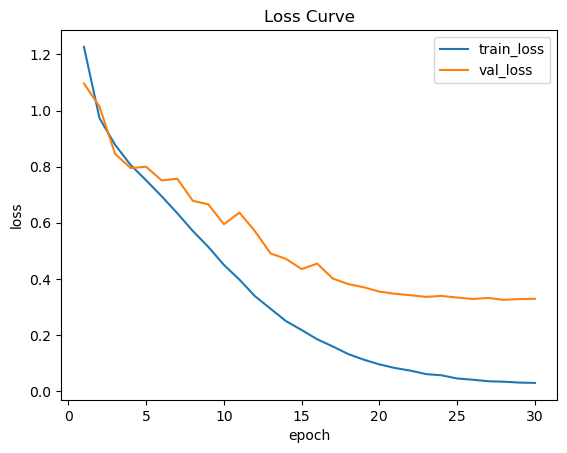

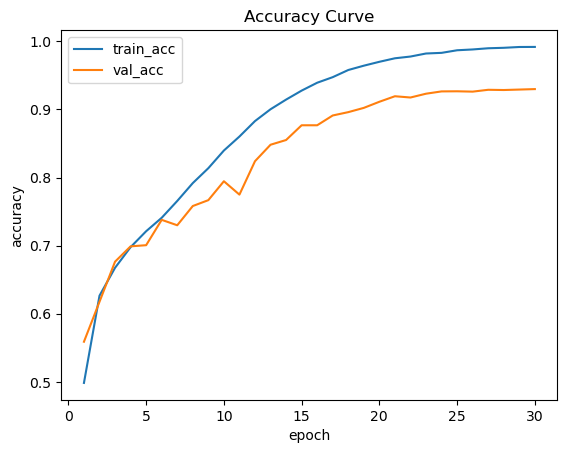

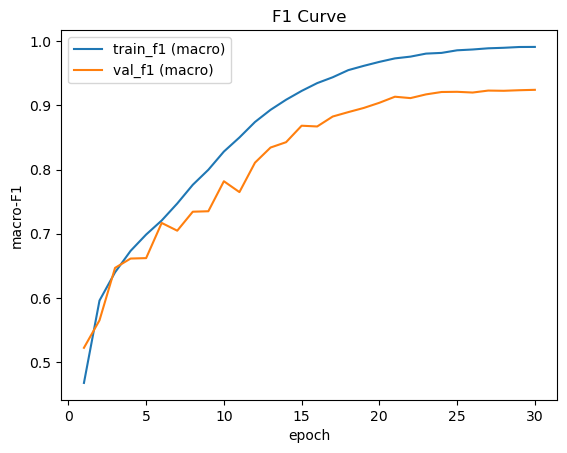


Classification Report:
              precision    recall  f1-score   support

       Angry     0.9329    0.9172    0.9250      1015
        Fear     0.8897    0.8787    0.8842       973
       Happy     0.9733    0.9691    0.9712      1844
         Sad     0.8977    0.9220    0.9097      1256
     Suprise     0.9467    0.9501    0.9484       822

    accuracy                         0.9327      5910
   macro avg     0.9280    0.9274    0.9277      5910
weighted avg     0.9328    0.9327    0.9327      5910



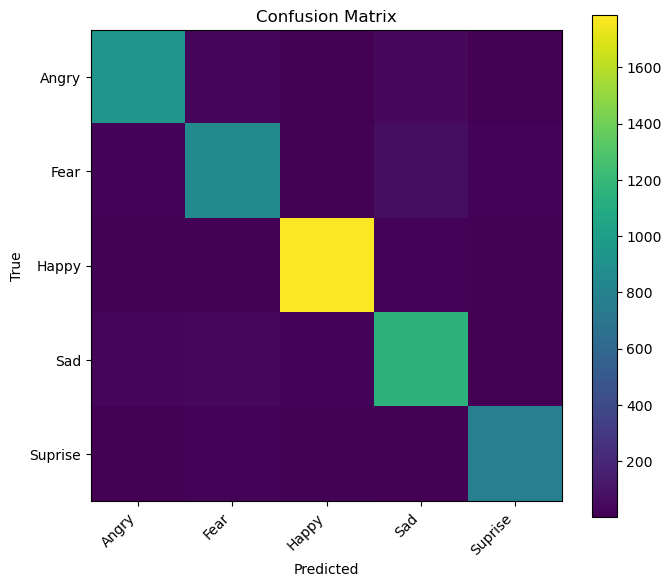

In [ ]:
if __name__ == "__main__":
    

    BASE_DIR = "./data"
    

    DATA_DIR = "D:\\studyAbout\\EEP596DAbout\\final_project\\Data"

    cfg = Config(
        seed=42,
        batch_size=64,
        epochs=30,
        lr=2e-4,
        early_stop_patience=5,
        save_path="best_seresnet18.pth",
        use_class_weights=True,
        label_smoothing=0.0,
        se_reduction=16,
    )

    model, history, meta, loaders = train(DATA_DIR, cfg)
    train_loader, val_loader, test_loader = loaders

    plot_history(history)
    evaluate_report(model, test_loader, meta["class_names"])